In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime
import time
import torch
import torch.utils.data as torch_data
from torch import nn
from torchinfo import summary
import copy
import nn_helpers
import data_preprocessing

In [2]:
ds = data_preprocessing.get_data('BTC-USD')
ds

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...,...
2804,2022-05-22,29432.472656,30425.861328,29275.183594,30323.722656,30323.722656,21631532270
2805,2022-05-23,30309.396484,30590.585938,28975.560547,29098.910156,29098.910156,31483454557
2806,2022-05-24,29101.125000,29774.355469,28786.589844,29655.585938,29655.585938,26616506245
2807,2022-05-25,29653.134766,30157.785156,29384.949219,29562.361328,29562.361328,27525063551


In [3]:
ds['Date'] = ds['Date'].astype('datetime64')
ds = ds.sort_values('Date')

In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2809 entries, 0 to 2808
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2809 non-null   datetime64[ns]
 1   Open       2809 non-null   float64       
 2   High       2809 non-null   float64       
 3   Low        2809 non-null   float64       
 4   Close      2809 non-null   float64       
 5   Adj Close  2809 non-null   float64       
 6   Volume     2809 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 175.6 KB


In [5]:
ds = ds[ds['Date'] >= '2020-10-01']

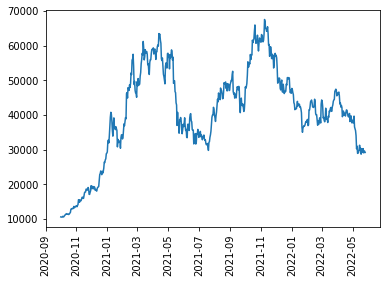

In [31]:
plt.plot(ds['Date'], ds['Close'])
plt.xticks(rotation=90)
plt.show()

In [7]:
data_seq = np.array(ds['Close'].tolist()).reshape(-1, 1)

In [8]:
scaler = MinMaxScaler()
scaled_data_seq = scaler.fit_transform(data_seq)

In [9]:
scaled_data_seq = scaled_data_seq[~np.isnan(scaled_data_seq)]
scaled_data_seq = scaled_data_seq.reshape(-1, 1)

In [10]:
seq_len = 10

train_iter, test_iter = data_preprocessing.prepare_data(scaled_data_seq, seq_len, 0.8, 16)

In [16]:
hidden_size, num_layers, dropout_prob = 200, 2, 0.2
net = nn_helpers.RNNModel(seq_len, hidden_size, num_layers, dropout_prob, bidirectional=False, num_hidden_neutrons=[], recur_ctor=nn.GRU)

# for future: 100 hid size + 40 hid neutrons gave excellent result

print(summary(net, input_size=(16, seq_len - 1, 1)))

lr, num_epochs = 0.0008, 60
loss = nn.MSELoss()
trainer = torch.optim.Adam(net.parameters(), lr=lr)
train_losses, test_losses = nn_helpers.train_model(net, train_iter, test_iter, loss, trainer, num_epochs)

Layer (type:depth-idx)                   Output Shape              Param #
RNNModel                                 --                        --
├─GRU: 1-1                               [9, 16, 200]              363,000
├─Linear: 1-2                            [16, 1]                   201
Total params: 363,201
Trainable params: 363,201
Non-trainable params: 0
Total mult-adds (M): 52.28
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 1.45
Estimated Total Size (MB): 1.68
started epoch 1/60
	batch 20/30 loss: 0.018386531187570655
epoch 1/60, train loss: 0.04805593521450646, test loss: 0.09607785181530441
started epoch 2/60
	batch 20/30 loss: 0.10476140360697173
epoch 2/60, train loss: 0.07370610327537482, test loss: 0.023006748668073364
started epoch 3/60
	batch 20/30 loss: 0.04549331507878378
epoch 3/60, train loss: 0.032181670897019406, test loss: 0.007117308016556005
started epoch 4/60
	batch 20/30 loss: 0.01441614369105082
epoch 4/60, train loss: 0.01085

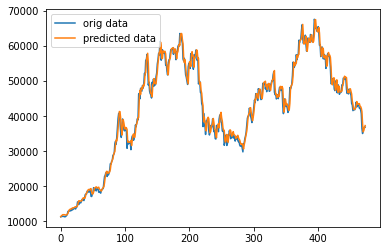

In [23]:
X_test, y_test = test_iter.dataset.tensors

y_pred = net(X_test)

y_test_inv = scaler.inverse_transform(y_test.detach().numpy())
y_pred_inv = scaler.inverse_transform(y_pred.detach().numpy())
plt.plot(y_test_inv, label='orig data')
plt.plot(y_pred_inv, label='predicted data')
plt.legend(loc='upper left')
plt.show()

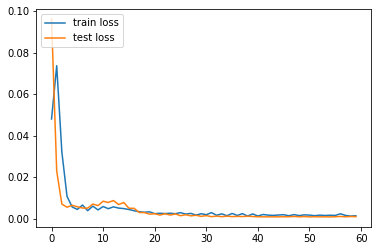

In [22]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend(loc='upper left')
plt.show()